In [2]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from TTGP.gpstruct import TTGPstruct
from TTGP import grid
from TTGP.covariance import SE_multidim
from TTGP.projectors import LinearProjector
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data Loading

In [3]:
x_tr = np.load('data_struct_raw/x_tr.npy')
x_te = np.load('data_struct_raw/x_te.npy')
y_tr = np.load('data_struct_raw/y_tr.npy')
y_te = np.load('data_struct_raw/y_te.npy')

In [3]:
D = x_tr.shape[-1]
d = 4

In [4]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [5]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [6]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [7]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

In [8]:
max_len = x_tr.shape[1]
n_labels = 4
n_seq = x_tr.shape[0]

## GP

In [9]:
num = 10
inputs = grid.InputsGrid(d, left=-1., right=1., npoints=num)
projector = LinearProjector(d=d, D=D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)

In [10]:
mu_ranks = 5
gp = TTGPstruct(cov, inputs, mu_ranks)

## Graph Creation

In [11]:
seq_lens = np.ones(shape=(n_seq,)) * max_len

In [12]:
x_tr = tf.constant(x_tr)
x_te = tf.constant(x_te)
y_tr = tf.constant(y_tr)
y_te = tf.constant(y_te)
seq_lens = tf.constant(seq_lens)

In [49]:
N = n_seq
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(5e-3, global_step, 
                                        100, 0.5, staircase=True)

In [50]:
elbo_op, train_op = gp.fit(x_tr, y_tr, seq_lens, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 64) = sum_len x 64
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 100, 3, 3) = [4, 100, 3, 3]
_Knns/K_nn (4, 100, 3, 3) = 4 x 100 x 3 x 3
_sample_f/f_un (4, 100, 3) = 4 100 3
_sample_f/f_bin (16,) = 16


## Learning

In [51]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())

In [52]:
maxiter = 300
elbo_vals = []
for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(i, elbo)
    elbo_vals.append(elbo)

0 464.389605657
1 469.325264351
2 464.225281895
3 464.103607365
4 461.039106547
5 456.642409406
6 455.519321204
7 453.440839583
8 451.595236326
9 451.419728878
10 448.966928307
11 447.064303824
12 444.699205903
13 443.31371091
14 441.676387853
15 442.934839816
16 438.701531759
17 439.817589968
18 437.361046333
19 436.413162768
20 436.20681851
21 434.219706149
22 433.632996714
23 433.50855751
24 431.546484412
25 431.297956559
26 430.950191883
27 430.113520326
28 428.825282991
29 427.268468641
30 427.803188472
31 424.965191694
32 427.058262618
33 426.41028419
34 424.79905536
35 425.206936188
36 424.267460373
37 424.273054791
38 423.864077075
39 423.286860921
40 422.274543761
41 422.503420602
42 422.369870963
43 421.026402419
44 421.013148758
45 420.597693921
46 419.895147294
47 420.201899347
48 419.052959783
49 419.375425634
50 418.85950859
51 419.481557508
52 417.948322671
53 418.730780714
54 418.090120079
55 418.043683223
56 417.053667557
57 417.001479898
58 418.514400529
59 417.463010

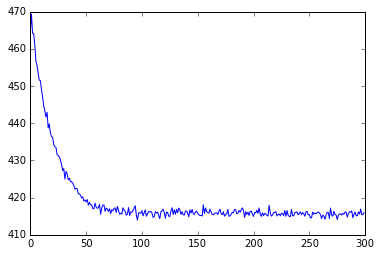

In [53]:
plt.plot(elbo_vals)

In [54]:
bin_mu = sess.run(gp.bin_mu)

In [55]:
for i in range(4):
    for j in range(4):
        print(i, j, bin_mu[i * 4 + j])

0 0 0.294764100966
0 1 0.16827198737
0 2 -0.384310202282
0 3 -0.448631808088
1 0 -0.34329691737
1 1 0.219485846511
1 2 0.43132449147
1 3 -0.427622453957
2 0 -0.45624399444
2 1 -0.419226727986
2 2 0.38190934795
2 3 0.408819439629
3 0 0.367519930072
3 1 -0.404162037658
3 2 -0.407287436863
3 3 0.468818320945


## Prediction

In [56]:
seq_lens_te = tf.constant(np.ones([x_te.shape[0]]) * max_len)

In [57]:
preds = gp.predict(x_te, seq_lens_te, sess)

_latent_vars_distribution/x_flat (?, 64) = sum_len x 64
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 4
cov_for_squared_dists/cov (4, 50, 3, 3) = [4, 50, 3, 3]
_Knns/K_nn (4, 50, 3, 3) = 4 x 50 x 3 x 3


In [58]:
np.sum(sess.run(y_te) == preds) / preds.size

0.98666666666666669

In [48]:
sess.close()